In [1]:
from pathlib import Path
from tqdm import tqdm
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


### Load data and divide into train and test set:

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "segmented_shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
labels = []
image_paths = []
for key, item in list(image_dict.items()):
    for image_path in item:
        labels.append(list(image_dict.keys()).index(key))
        image_paths.append(image_path)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=205)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=205)
print(len(X_train), len(X_val), len(X_test))
print(*image_dict.keys(), sep=', ')

Astrocitoma, Carcinoma, Ependimoma, Germinoma, Glioblastoma, Meduloblastoma, Meningioma, Neurocitoma, Oligodendroglioma, Papiloma, Schwannoma, Tuberculoma, _NORMAL


In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, data_path, image_paths, labels, transform=None, transform_label=None):
        self.data_path = data_path
        self.image_paths = image_paths
        self.image_class_list = labels
        self.transform = transform
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_class_list)

    def __getitem__(self, idx):
        label = self.image_class_list[idx]
        img_path = os.path.join(self.data_path, self.image_paths[idx])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label

### GAN model:

In [4]:
class GAN(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        # generator
        self.latent_dim = latent_dim
        self.generator = nn.Sequential(nn.ConvTranspose2d(self.latent_dim, 128, kernel_size=3, stride=4),
                                     nn.ReLU(inplace=True),
                                     nn.ConvTranspose2d(128, 64, kernel_size=3, stride=6, padding=4, output_padding=2),
                                     nn.ReLU(inplace=True),
                                     nn.ConvTranspose2d(64, 16, kernel_size=3, stride=6, padding=4, output_padding=2),
                                     nn.ReLU(inplace=True),
                                     nn.ConvTranspose2d(16, 1, kernel_size=3, stride=6, padding=6, output_padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.Tanh())
        
        # discriminator
        self.discriminator = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=2),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(16, 64, kernel_size=3, stride=2, padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=0),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(512, 1, kernel_size=3, stride=2, padding=0),
                                     nn.Flatten(),
                                     nn.Linear(49, 1),
                                     nn.Sigmoid())
    
    def generate(self):
        latent = torch.randn(batch_size, self.latent_dim, 1, 1, device=device)
        fake_images = self.generator(latent)
        return fake_images
    
    def discriminate(self, x):
        pred = self.discriminator(x)
        return pred

### Training and evaluation

#### Hyperparameters set

In [5]:
learning_rate = 3e-5
batch_size = 64
epochs = 100
weight = 0.7

#### Load dataset into Dataloaders

Feature batch shape: torch.Size([64, 1, 256, 256])
Labels batch shape: torch.Size([64])


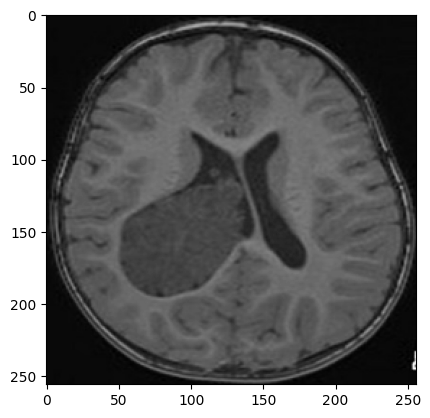

Label: 9


In [6]:
train_dataset = BrainTumorDataset(data_path, X_train, y_train, transform=training_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BrainTumorDataset(data_path, X_test, y_test, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_dataset = BrainTumorDataset(data_path, X_val, y_val, transform=transforms.ToTensor())
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(image, cmap="gray")
plt.show()
print(f"Label: {label}")

#### Load model and modify

In [7]:
model = GAN()
model.to(device)

GAN(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(3, 3), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(6, 6), padding=(4, 4), output_padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 16, kernel_size=(3, 3), stride=(6, 6), padding=(4, 4), output_padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(6, 6), padding=(6, 6), output_padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Tanh()
  )
  (discriminator): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU(inplace=True)
    (8): Conv2d(

#### Training loop

In [8]:
MSE = nn.MSELoss()
#params = [p for p in model.parameters() if p.requires_grad]
opt_g = torch.optim.Adam(model.generator.parameters(), lr=learning_rate)
opt_d = torch.optim.Adam(model.discriminator.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [9]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = model.discriminate(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    fake_images = model.generate()

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = model.discriminate(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score



def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    fake_images = model.generate()
    
    # Try to fool the discriminator
    preds = model.discriminate(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

------------ Epoch: 0 ------------
Epoch [1/100], loss_g: 0.8545, loss_d: 1.0810, real_score: 0.5966, fake_score: 0.4309
Time elapsed: 5.663016080856323
------------ Epoch: 1 ------------
Epoch [2/100], loss_g: 2.2322, loss_d: 0.2654, real_score: 0.8697, fake_score: 0.1143
Time elapsed: 4.050976037979126
------------ Epoch: 2 ------------
Epoch [3/100], loss_g: 4.4170, loss_d: 0.0193, real_score: 0.9934, fake_score: 0.0126
Time elapsed: 4.072991371154785
------------ Epoch: 3 ------------
Epoch [4/100], loss_g: 5.3373, loss_d: 0.0121, real_score: 0.9932, fake_score: 0.0048
Time elapsed: 3.945714235305786
------------ Epoch: 4 ------------
Epoch [5/100], loss_g: 5.9202, loss_d: 0.0031, real_score: 0.9997, fake_score: 0.0027
Time elapsed: 3.9680609703063965
------------ Epoch: 5 ------------
Epoch [6/100], loss_g: 6.3725, loss_d: 0.0018, real_score: 1.0000, fake_score: 0.0017
Time elapsed: 3.9504644870758057
------------ Epoch: 6 ------------
Epoch [7/100], loss_g: 6.8616, loss_d: 0.0019

Text(0.5, 0, 'Epoch')

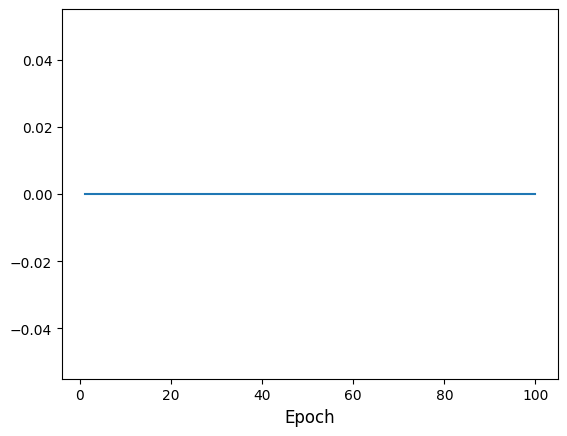

In [10]:
torch.cuda.empty_cache()
all_loss = []
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

for epoch in range(epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    total_loss = 0
    start = time.time()
    real_loss = 0
    fake_loss = 0
    loss_d = 0
    loss_g = 0
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        
        # Train discriminator
        loss_d, real_score, fake_score = train_discriminator(X, opt_d)
        # Train generator
        loss_g = train_generator(opt_g)

        
    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(total_loss)

fig = plt.figure()
plt.plot(range(1, epochs+1), all_loss)
plt.xlabel('Epoch', fontsize=12)

In [11]:
for batch, (X, y) in enumerate(train_dataloader):
    mu, log_var = model.encode(X.to(device))
    mu = mu.to('cpu').detach().numpy()
    plt.scatter(mu[:, 0], mu[:, 1], c=y, cmap='tab10')
    if batch > 41:
        plt.colorbar()
        break

AttributeError: 'GAN' object has no attribute 'encode'